In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import easyocr
import requests
from google.colab.patches import cv2_imshow


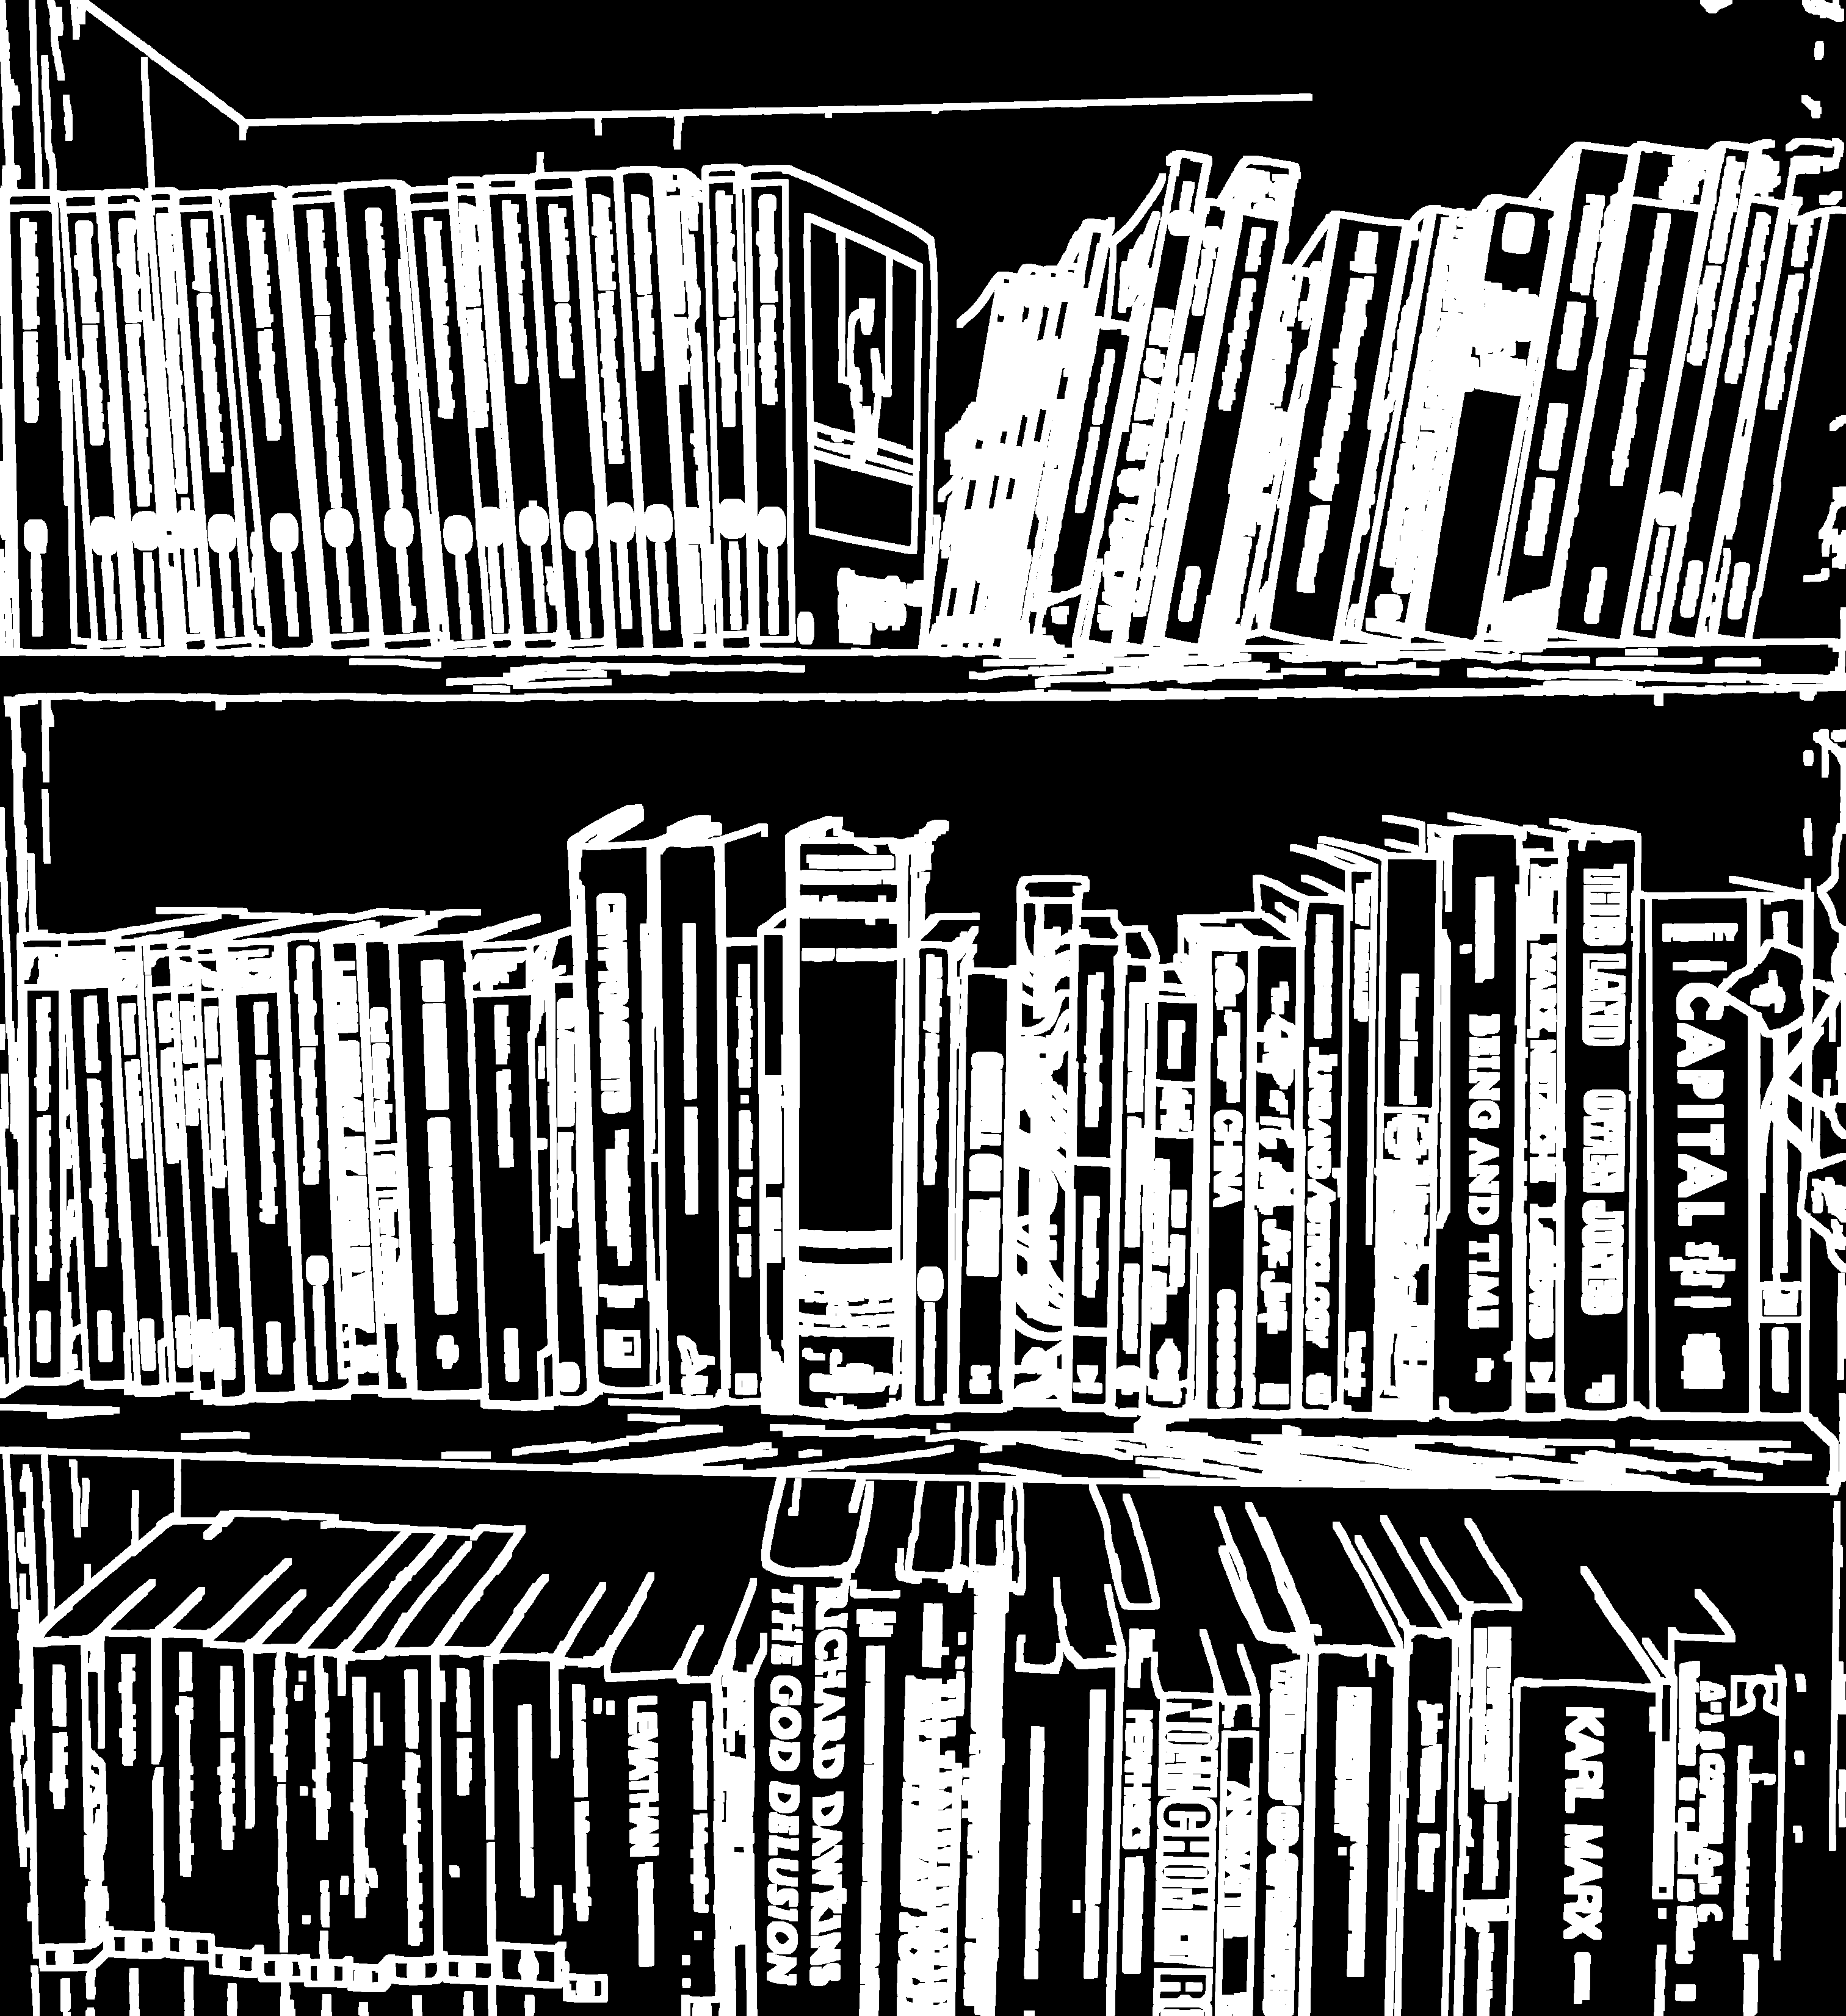

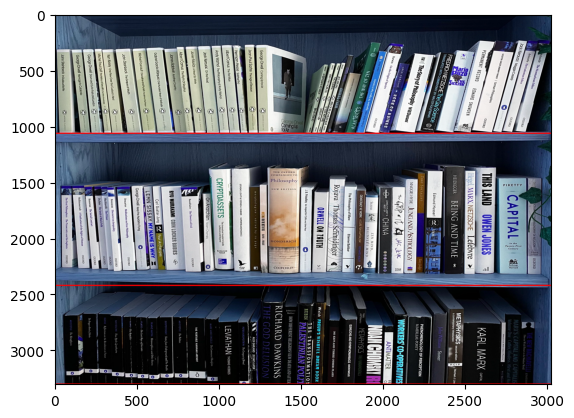

In [6]:
fileName = input("Enter file name: ")
img = cv2.imread('images/'+fileName)

(height, width, _) = img.shape

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kernel_size = 3
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

edges = cv2.Canny(blur_gray, 50, 150, apertureSize=3)
kernel = np.ones((3,3), np.uint8);
canned = cv2.dilate(edges, kernel, iterations = 5);

# plt.imshow(canned, cmap='gray', aspect='auto')

# cv2_imshow(canned)

list = []
goodList = [0]

cropped = []

lines = cv2.HoughLinesP(canned, 1, np.pi/180, 100, minLineLength=0.6*width, maxLineGap=5)
for line in lines:
    x1, y1, x2, y2 = line[0]
    if (not (x1 == x2)) and abs((y2 - y1)/(x2 - x1)) < 0.2:
      list.append((y1+y2)//2)

list.sort()
for i in range(0, len(list)):
  if list[i] - goodList[-1] > 0.1 * height:
    goodList.append(list[i])

goodList.append(height)
for y in goodList:
  cv2.line(img, (0, y), (width, y), (255, 0, 0), 10)
plt.imshow(img, aspect='auto')

for i in range(1, len(goodList)):
  crop_img = img[goodList[i-1]:goodList[i], 0:width]
  cropped.append(crop_img)




In [10]:
class Book:
  def __init__(self):
    self.row = -1
    self.Title = ""
    self.Authors = ""
    self.ISBN_10 = ""
    self.ISBN_13 = ""

bookList = []


def draw_bounding_boxes(image, result, threshold):
  for (bbox, text, score) in result:
    if score > threshold:
      (x1, y1) = tuple(map(int, bbox[0]))
      (x2, y2) = tuple(map(int, bbox[2]))
      cv2.rectangle(image, (x1, y1 + (y2 - y1)//3), (x2, y2 - (y2 - y1)//3), (0, 255, 0), 5)

def valid(text):
  # length check: at least 5 characters
  if(len(text) < 5):
    return False
  # at least 2 words in info
  if(text.count(' ') == 0):
    return False

  return True

def find_book(result, threshold, row):
  for (bbox, text, score) in result:
    book = Book()
    if (score > threshold) and valid(text):
      response = requests.get("https://www.googleapis.com/books/v1/volumes?q="+text+"&maxResults=1")
      if(response.status_code == 200):
        book.row = row
        # find title
        try:
          data = response.json()
          # print(data['items'][0]['volumeInfo']['title'])
          book.Title = data['items'][0]['volumeInfo']['title']
        except Exception:
          continue
        # find author
        try:
          # print("Author(s) ", end="")
          # print(*(data['items'][0]['volumeInfo']['authors']), sep=", ")
          book.Authors = ", ".join(author for author in data['items'][0]['volumeInfo']['authors'])
        except:
          pass
        # find ISBN
        try:
          # ISBN
          for info in data['items'][0]['volumeInfo']['industryIdentifiers']:
            if(info['type'] == "ISBN_10"):
              book.ISBN_10 = info['identifier']
            elif(info['type'] == "ISBN_13"):
              book.ISBN_13= info['identifier']
        except:
          pass
        bookList.append(book)


In [96]:
response = requests.get("https://www.googleapis.com/books/v1/volumes?q=The prince niccolo machiavelli&maxResults=1")
print(response.json())

{'kind': 'books#volumes', 'totalItems': 826, 'items': [{'kind': 'books#volume', 'id': 'kWBAAAAAYAAJ', 'etag': 'qPbPgmNUCk0', 'selfLink': 'https://www.googleapis.com/books/v1/volumes/kWBAAAAAYAAJ', 'volumeInfo': {'title': 'The prince', 'authors': ['Niccolò Machiavelli'], 'publisher': 'Grant Richards', 'publishedDate': '1903', 'industryIdentifiers': [{'type': 'OTHER', 'identifier': 'HARVARD:HN3AWZ'}], 'readingModes': {'text': True, 'image': True}, 'pageCount': 128, 'printType': 'BOOK', 'categories': ['Political ethics'], 'averageRating': 4, 'ratingsCount': 139, 'maturityRating': 'NOT_MATURE', 'allowAnonLogging': False, 'contentVersion': '1.4.9.0.full.3', 'panelizationSummary': {'containsEpubBubbles': False, 'containsImageBubbles': False}, 'imageLinks': {'smallThumbnail': 'http://books.google.com/books/content?id=kWBAAAAAYAAJ&printsec=frontcover&img=1&zoom=5&edge=curl&source=gbs_api', 'thumbnail': 'http://books.google.com/books/content?id=kWBAAAAAYAAJ&printsec=frontcover&img=1&zoom=1&edge

In [8]:
reader = easyocr.Reader(['en'])
for i in range(0, len(cropped)):
  img = cropped[i]
  img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
  result = reader.readtext(img, width_ths=10)
  find_book(result, 0.1, i)




Progress: |██████████████████████████████████████████████████| 100.0% Complete

KeyboardInterrupt: 

In [112]:
for book in bookList:
  print("row:", book.row)
  print("title:", book.Title)
  print("authors:", book.Authors)
  print("ISBN_10:", book.ISBN_10)
  print("ISBN_13:", book.ISBN_13)
  print("")

row: 0
title: On the Beach
authors: Nevil Shute
ISBN_10: 0307476987
ISBN_13: 9780307476982

row: 0
title: Coming Up for Air [by] George Orwell
authors: George Orwell
ISBN_10: 
ISBN_13: 

row: 0
title: The Age of Reason
authors: Thomas Paine
ISBN_10: 
ISBN_13: 

row: 0
title: Siddhartha
authors: Hermann Hesse
ISBN_10: 1775412490
ISBN_13: 9781775412496

row: 0
title: The First Man
authors: Albert Camus
ISBN_10: 0307827860
ISBN_13: 9780307827869

row: 0
title: The Philosophy of Andy Warhol
authors: Andy Warhol
ISBN_10: 0156717204
ISBN_13: 9780156717205

row: 0
title: On the Road
authors: Jack Kerouac
ISBN_10: 0142437255
ISBN_13: 9780142437254

row: 0
title: The Infatuations
authors: Javier Marías
ISBN_10: 0307960730
ISBN_13: 9780307960733

row: 0
title: The Myth of Sisyphus And Other Essays
authors: Albert Camus
ISBN_10: 0307827828
ISBN_13: 9780307827821

row: 0
title: Another Country
authors: James Baldwin
ISBN_10: 0804149712
ISBN_13: 9780804149716

row: 0
title: One Hundred Years of Sol

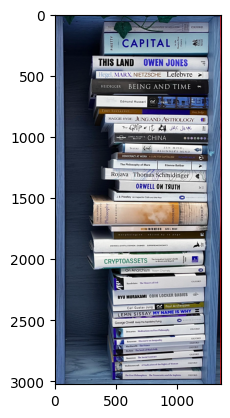

Popular Photography


points:  433 108 486 107 920 108 875 108
points:  0 156 1358 156 1257 315 1016 319
points:  356 365 402 366 443 423 390 423
points:  644 493 704 493 461 495 388 494
points:  644 497 704 497 986 505 943 504
points:  376 591 420 591 417 592 376 592
points:  646 712 741 715 741 716 683 717
points:  696 718 741 718 738 724 681 719
points:  0 763 1358 787 504 792 461 794
points:  461 795 504 793 411 815 357 814
points:  980 855 1032 855 743 856 701 856
points:  473 863 547 864 547 865 504 865
points:  868 898 1254 904 1358 980 0 957
points:  1052 1010 1128 1011 1155 1012 1102 1012
points:  1113 1070 1176 1072 923 1123 838 1126
points:  838 1126 923 1123 1290 1127 1245 1126
points:  842 1161 891 1161 973 1161 868 1163
points:  696 1164 750 1167 922 1170 822 1165
points:  821 1169 868 1171 960 1176 909 1174
points:  586 1228 658 1230 977 1233 900 1231
points:  904 1235 978 1236 977 1238 906 1236
points:  814 1309 897 1310 904 1314 853 1313
points:  1029 1315 1096 1316 512 1321 466 1323
points

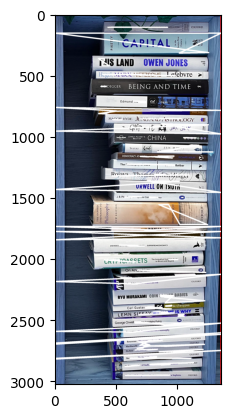